## Теоретическая часть


1. Ответьте на вопросы:  
В чем принципиальное отличие гибридных рекомендательных систем от коллаборативной филтьтрации?  
Приведите 2-3 примера задач, в которых необходимо использовать гибридные системы  




2.  Прочитайте статью про поиск на hh.ru https://habr.com/ru/company/hh/blog/347276/
Нам интересна именно рекомендательная система, раздел "Производительность системы" можно пропустить
Какие основные отличия предложенной системы от тех подходов, которые мы разбирали на семинарах? Какие проблемы могут возникнуть при выводе такой модели в продакшен?

3. На вебинаре мы рассматривали модель LightFM (https://making.lyst.com/lightfm/docs/lightfm.html). В работе Data Scientist'а важную часть занимает research - исследование существующих архитектур и разбор научных статей, в которых они описываются. Вам предлагается изчуть оригинальную статью про LightFM https://arxiv.org/pdf/1507.08439.pdf и ответить на следующие вопросы:  
1) Какой датасет используют авторы?  
2) Что используют в качестве признаков?  
3) С какими моделями сравнивают LightFM? Опишите их основные идеи кратко  

## Практическая часть


In [3]:
import lightfm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
# from lightfm.evaluation import precision_at_k, recall_at_k

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.recommenders import MainRecommender    
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items_top_n_999999
import lightfm.evaluation
pr = lightfm.evaluation.precision_at_k

In [151]:
# Подготовка данных
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]


data_train = prefilter_items_top_n_999999(data_train)

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

test_user_item_matrix = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

test_user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit
# переведем в формат sparse matrix
sparse_test_user_item = csr_matrix(test_user_item_matrix).tocsr()

userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']


### Работа с признаками

У нас есть внешние данные. Что с ними не так? Чего не хватает?  

Проведите исследование внешних данных и составьте какие-нибудь содержательные выводы.  
Формально Вам нужно построить 3+ графиков (scatter plot, hist или что-то иное) и описать, что мы видим (например, товары такой-то категории болле часто покупаются в следующие дни недели или пользователи с большим достатком предпочитают такие-то товары).  
Исследуйте те закономерности, которые Вам интересно, чем менее тривиальный вывод получается, тем лучше! 

In [113]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)

item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

In [114]:
user_feat

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2496,45-54,A,75-99K,Homeowner,Unknown,3,1
2497,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown
2498,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown


In [115]:
user_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2499 entries, 1 to 2500
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age_desc             801 non-null    object
 1   marital_status_code  801 non-null    object
 2   income_desc          801 non-null    object
 3   homeowner_desc       801 non-null    object
 4   hh_comp_desc         801 non-null    object
 5   household_size_desc  801 non-null    object
 6   kid_category_desc    801 non-null    object
dtypes: object(7)
memory usage: 156.2+ KB


In [116]:
user_feat.age_desc.value_counts()

45-54    288
35-44    194
25-34    142
65+       72
55-64     59
19-24     46
Name: age_desc, dtype: int64

In [117]:
data_user_item = data.merge(user_feat,on = 'user_id',how='left')
data_user_item = data_user_item.merge(item_feat,on='item_id',how = 'left')

In [118]:
age_desc = data_user_item.groupby(by='age_desc')[['quantity','sales_value']].sum()
age_desc

,quantity,sales_value
age_desc,,
19-24,4846889,2.008357e+05
25-34,28584229,7.141780e+05
35-44,44928094,1.147748e+06
45-54,53623390,1.528941e+06
55-64,10935733,2.751147e+05
65+,8357075,2.849592e+05


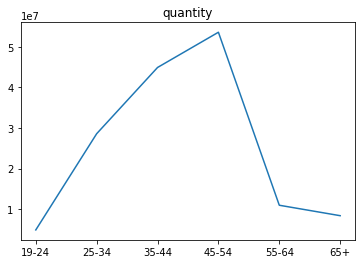

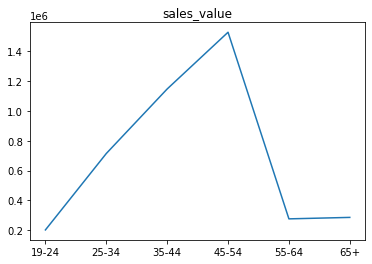

In [119]:
plt.plot(age_desc.index,age_desc['quantity'])
plt.title('quantity')
plt.show()
plt.plot(age_desc.index,age_desc['sales_value'])
plt.title('sales_value')
plt.show()

In [120]:
age_desc.sort_values(by='sales_value')

,quantity,sales_value
age_desc,,
19-24,4846889,2.008357e+05
55-64,10935733,2.751147e+05
65+,8357075,2.849592e+05
25-34,28584229,7.141780e+05
35-44,44928094,1.147748e+06
45-54,53623390,1.528941e+06


In [121]:
lst = age_desc.sort_values(by='quantity').index.to_list()
map_dict = dict(zip(lst,range(1,len(lst)+1)))
user_feat['age_desc'] = user_feat['age_desc'].map(map_dict)

In [122]:
map_dict

{'19-24': 1, '65+': 2, '55-64': 3, '25-34': 4, '35-44': 5, '45-54': 6}

=========================   marital_status_code   =========================
                     quantity   sales_value
marital_status_code                        
A                    75479574  1.924136e+06
B                    17424858  5.521240e+05
U                    58370978  1.675517e+06


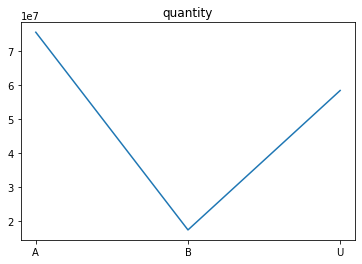

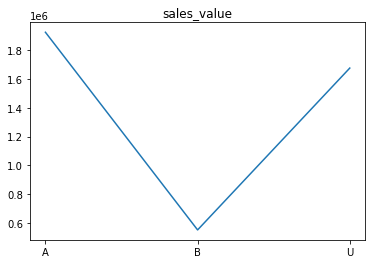

                     quantity   sales_value
marital_status_code                        
B                    17424858  5.521240e+05
U                    58370978  1.675517e+06
A                    75479574  1.924136e+06
=========================   income_desc   =========================
             quantity   sales_value
income_desc                        
100-124K     10007250  1.868494e+05
125-149K     12378268  2.772141e+05
15-24K        7559227  2.846853e+05
150-174K      9575452  2.323302e+05
175-199K      3208442  8.805055e+04
200-249K       183266  2.535137e+04
25-34K       10116978  3.503746e+05
250K+         1634965  1.094730e+05
35-49K       26364096  7.635334e+05
50-74K       40428379  1.006854e+06
75-99K       19933129  5.129857e+05
Under 15K     9885958  3.140754e+05


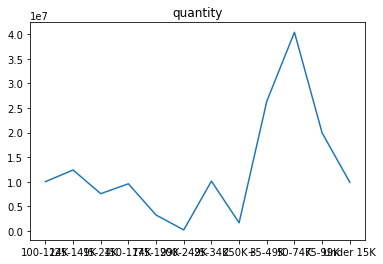

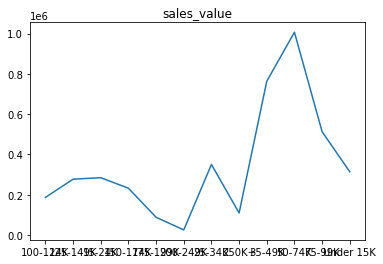

             quantity   sales_value
income_desc                        
200-249K       183266  2.535137e+04
250K+         1634965  1.094730e+05
175-199K      3208442  8.805055e+04
15-24K        7559227  2.846853e+05
150-174K      9575452  2.323302e+05
Under 15K     9885958  3.140754e+05
100-124K     10007250  1.868494e+05
25-34K       10116978  3.503746e+05
125-149K     12378268  2.772141e+05
75-99K       19933129  5.129857e+05
35-49K       26364096  7.635334e+05
50-74K       40428379  1.006854e+06
=========================   homeowner_desc   =========================
                  quantity   sales_value
homeowner_desc                          
Homeowner        112198864  2.799809e+06
Probable Owner      992558  5.016835e+04
Probable Renter    1568508  4.328006e+04
Renter             7858536  2.192285e+05
Unknown           28656944  1.039291e+06


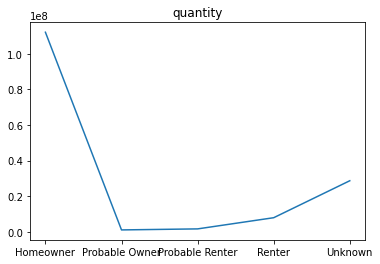

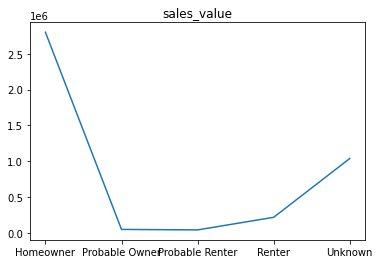

                  quantity   sales_value
homeowner_desc                          
Probable Owner      992558  5.016835e+04
Probable Renter    1568508  4.328006e+04
Renter             7858536  2.192285e+05
Unknown           28656944  1.039291e+06
Homeowner        112198864  2.799809e+06
=========================   hh_comp_desc   =========================
                  quantity   sales_value
hh_comp_desc                            
1 Adult Kids       6619539  2.626599e+05
2 Adults Kids     44935705  1.115958e+06
2 Adults No Kids  49844064  1.342827e+06
Single Female     20721795  6.540686e+05
Single Male       14706709  4.261841e+05
Unknown           14447598  3.500797e+05


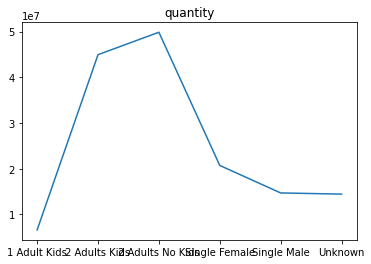

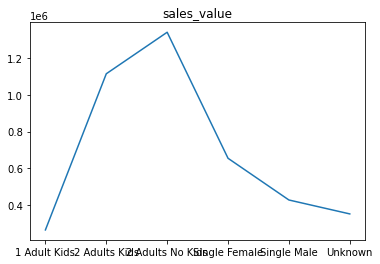

                  quantity   sales_value
hh_comp_desc                            
1 Adult Kids       6619539  2.626599e+05
Unknown           14447598  3.500797e+05
Single Male       14706709  4.261841e+05
Single Female     20721795  6.540686e+05
2 Adults Kids     44935705  1.115958e+06
2 Adults No Kids  49844064  1.342827e+06
=========================   household_size_desc   =========================
                     quantity   sales_value
household_size_desc                        
1                    42385153  1.185910e+06
2                    58795748  1.627200e+06
3                    18008674  6.099043e+05
4                    15898975  3.230430e+05
5+                   16186860  4.057199e+05


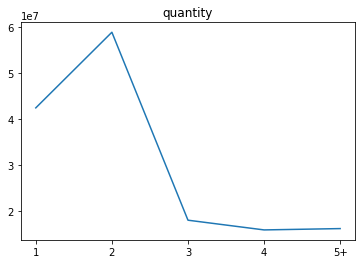

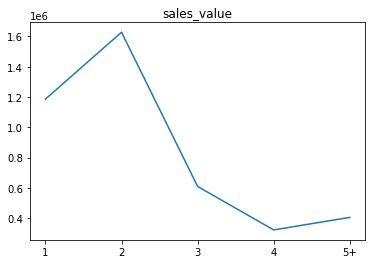

                     quantity   sales_value
household_size_desc                        
4                    15898975  3.230430e+05
5+                   16186860  4.057199e+05
3                    18008674  6.099043e+05
1                    42385153  1.185910e+06
2                    58795748  1.627200e+06
=========================   kid_category_desc   =========================
                   quantity   sales_value
kid_category_desc                        
1                  19253512  6.182177e+05
2                  16206209  3.737513e+05
3+                 16832830  4.268073e+05
None/Unknown       98982859  2.733000e+06


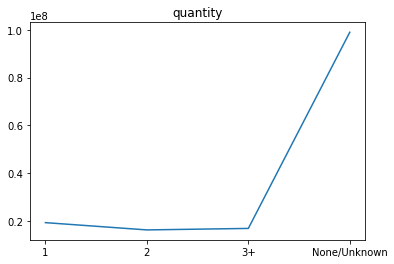

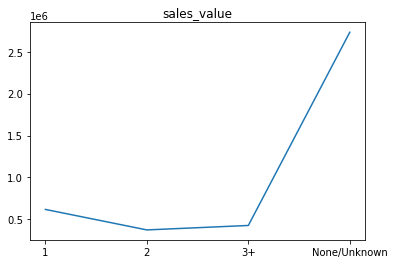

                   quantity   sales_value
kid_category_desc                        
2                  16206209  3.737513e+05
3+                 16832830  4.268073e+05
1                  19253512  6.182177e+05
None/Unknown       98982859  2.733000e+06


In [123]:
for i in user_feat.columns.to_list()[1:]:
    print(25*'='+'   ' + i + '   ' + 25*'=')
    df = data_user_item.groupby(by=i)[['quantity','sales_value']].sum()
    print(df)
    plt.plot(df.index,df['quantity'])
    plt.title('quantity')
    plt.show()
    plt.plot(df.index,df['sales_value'])
    plt.title('sales_value')
    plt.show()
    print(df.sort_values(by='quantity'))
    lst = df.sort_values(by='quantity').index.to_list()
    map_dict = dict(zip(lst,range(1,len(lst)+1)))
    user_feat[i] = user_feat[i].map(map_dict)
    

In [133]:
user_feat.fillna(0,inplace=True)

In [134]:
user_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2499 entries, 1 to 2500
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age_desc             2499 non-null   float64
 1   marital_status_code  2499 non-null   float64
 2   income_desc          2499 non-null   float64
 3   homeowner_desc       2499 non-null   float64
 4   hh_comp_desc         2499 non-null   float64
 5   household_size_desc  2499 non-null   float64
 6   kid_category_desc    2499 non-null   float64
dtypes: float64(7)
memory usage: 156.2 KB


In [135]:
user_feat.describe()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
count,2499.000000,2499.000000,2499.000000,2499.000000,2499.000000,2499.000000,2499.000000
mean,1.453782,0.730292,2.890756,1.444978,1.408163,1.249300,1.109244
std,2.287696,1.135393,4.524074,2.149644,2.227788,1.942703,1.699524
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,2.000000,6.000000,4.000000,3.000000,3.000000,3.000000
max,6.000000,3.000000,12.000000,5.000000,6.000000,5.000000,4.000000


In [126]:
user_feat

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,2.0,3.0,11.0,5.0,6.0,5.0,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2496,6.0,3.0,10.0,5.0,2.0,3.0,3.0
2497,6.0,2.0,11.0,4.0,3.0,4.0,4.0
2498,4.0,2.0,12.0,5.0,6.0,5.0,4.0


=========================   manufacturer   =========================
              quantity  sales_value
manufacturer                       
1.0                  0         0.00
2.0             200214    290265.56
5.0               4970     16167.11
10.0               224       275.59
16.0              2977      3852.95
...                ...          ...
6046.0             780      9710.00
6047.0             197       480.18
6078.0              95       252.69
6082.0            1160      2807.92
6331.0             560      2749.91

[610 rows x 2 columns]


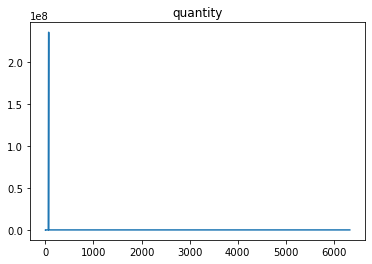

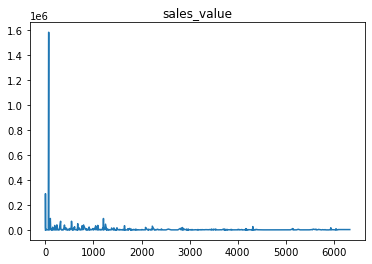

               quantity   sales_value
manufacturer                         
1.0                   0  0.000000e+00
6078.0               95  2.526900e+02
4207.0               99  4.886100e+02
3748.0              102  3.243000e+02
3711.0              104  2.908100e+02
...                 ...           ...
1208.0            40680  9.144545e+04
544.0             42278  6.943701e+04
103.0             42626  9.165645e+04
2.0              200214  2.902656e+05
69.0          235687305  1.581877e+06

[610 rows x 2 columns]
=========================   department   =========================
                  quantity   sales_value
department                              
                         0  0.000000e+00
CHEF SHOPPE            560  1.450460e+03
COUP/STR & MFG         321  0.000000e+00
DELI                 39430  1.479085e+05
DRUG GM              99604  1.474807e+05
FLORAL                1313  7.923400e+03
GROCERY            1405601  2.237572e+06
KIOSK-GAS        202577341  5.010345e+05
MEAT 

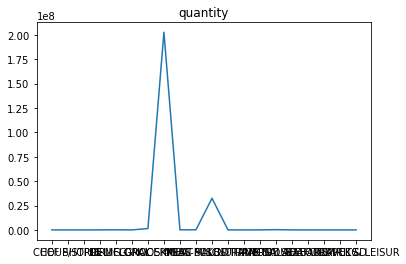

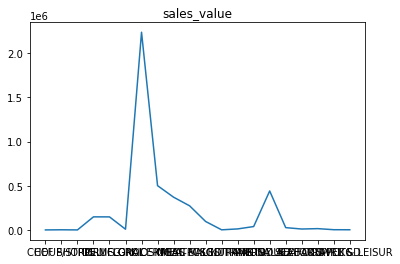

                  quantity   sales_value
department                              
                         0  0.000000e+00
SPIRITS                177  2.382230e+03
COUP/STR & MFG         321  0.000000e+00
CHEF SHOPPE            560  1.450460e+03
TRAVEL & LEISUR        652  1.769030e+03
FLORAL                1313  7.923400e+03
MISC. TRANS.          1479  1.056460e+03
SEAFOOD               1695  1.009855e+04
SEAFOOD-PCKGD         3099  1.452223e+04
NUTRITION             5522  1.131174e+04
SALAD BAR             8987  2.594456e+04
PASTRY               26267  3.812714e+04
DELI                 39430  1.479085e+05
MEAT                 86580  3.704794e+05
DRUG GM              99604  1.474807e+05
MEAT-PCKGD          103635  2.729088e+05
PRODUCE             266112  4.408718e+05
GROCERY            1405601  2.237572e+06
MISC SALES TRAN   32439954  9.555220e+04
KIOSK-GAS        202577341  5.010345e+05
=========================   brand   =========================
           quantity   sales_value
br

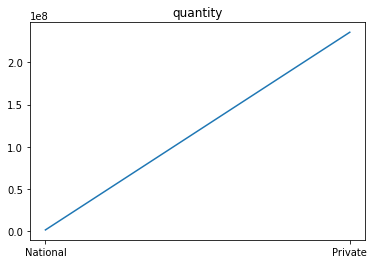

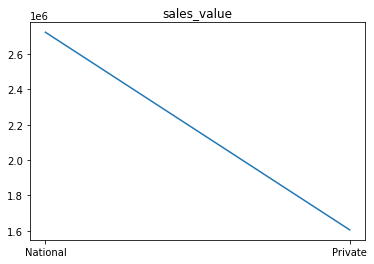

           quantity   sales_value
brand                            
National    1371673  2.723744e+06
Private   235696656  1.604649e+06
=========================   commodity_desc   =========================
                                quantity  sales_value
commodity_desc                                       
                                       0         0.00
AIR CARE                             298       301.54
ANTACIDS                             115      1213.85
APPLES                             14203     30655.24
AUTOMOTIVE PRODUCTS                  136       182.10
...                                  ...          ...
VEGETABLES SALAD                   11242     12414.06
WAREHOUSE SNACKS                    6294      7714.20
WATER                               2178      2165.80
WATER - CARBONATED/FLVRD DRINK     19070     42328.97
YOGURT                             61579     44248.01

[188 rows x 2 columns]


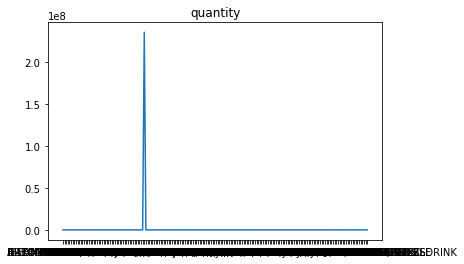

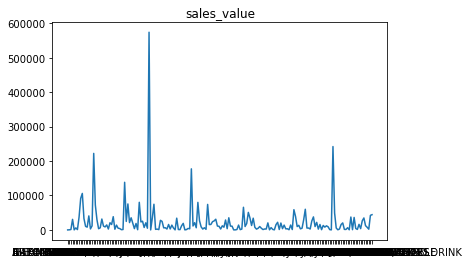

                          quantity  sales_value
commodity_desc                                 
                                 0         0.00
PACKAGED NATURAL SNACKS        113       234.56
DIETARY AID PRODUCTS           114       917.11
ANTACIDS                       115      1213.85
PARTY TRAYS                    125      1246.75
...                            ...          ...
CHEESE                       74571    138325.74
BAKED BREAD/BUNS/ROLLS       77801    105987.37
FLUID MILK PRODUCTS         101602    177402.39
SOFT DRINKS                 122905    242128.80
COUPON/MISC ITEMS        235017273    574156.59

[188 rows x 2 columns]
=========================   sub_commodity_desc   =========================
                          quantity  sales_value
sub_commodity_desc                             
                                 0         0.00
ADULT CEREAL                  5951     16873.71
AEROSOL TOPPINGS              1205      2651.51
AIR CARE - AEROSOLS            298   

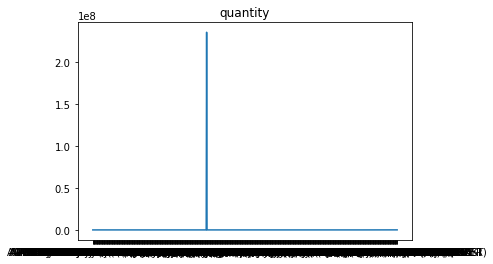

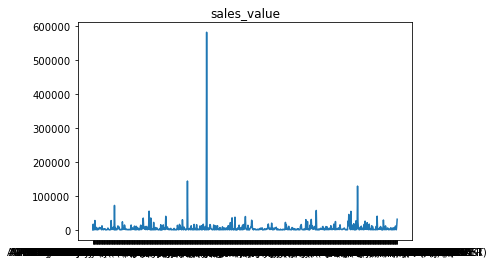

                                 quantity  sales_value
sub_commodity_desc                                    
                                        0         0.00
FLOOR - DILUTABLES                     95       252.69
CORNMEAL                               99       130.71
MISC MEAT SAUCES                      104       188.88
REFRIGERATED PICKLES                  105       224.40
...                                   ...          ...
SOFT DRINKS 12/18&15PK CAN CAR      45115    129011.85
SFT DRNK 2 LITER BTL CARB INCL      46829     45590.31
YOGURT NOT MULTI-PACKS              56522     31476.42
FLUID MILK WHITE ONLY               82011    143828.48
GASOLINE-REG UNLEADED           235014184    581753.35

[731 rows x 2 columns]
=========================   curr_size_of_product   =========================
                       quantity  sales_value
curr_size_of_product                        
                      235328080   1406638.10
(600) 4LB                  3340      6480.25
.13 

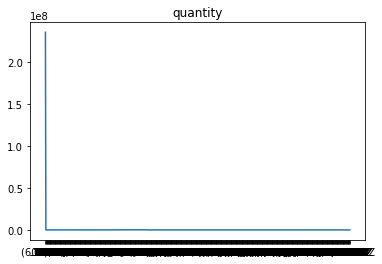

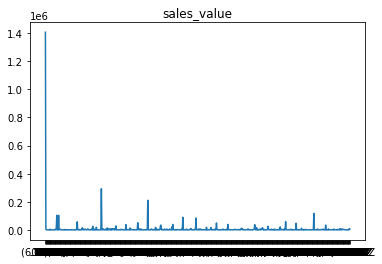

                       quantity  sales_value
curr_size_of_product                        
18.15 OZ                    101       337.69
500 SQ FT                   103      1015.02
20CT/13GAL                  103       454.01
25.2 OZ                     104       273.28
15CT                        106       422.94
...                         ...          ...
6 OZ                      74382     58940.14
8 OZ                      75823    117682.07
12 OZ                    106208    292710.50
16 OZ                    126041    210962.86
                      235328080   1406638.10

[670 rows x 2 columns]


In [127]:
for i in item_feat.columns.to_list():
    print(25*'='+'   ' + i + '   ' + 25*'=')
    df = data_user_item.groupby(by=i)[['quantity','sales_value']].sum()
    print(df)
    plt.plot(df.index,df['quantity'])
    plt.title('quantity')
    plt.show()
    plt.plot(df.index,df['sales_value'])
    plt.title('sales_value')
    plt.show()
    print(df.sort_values(by='quantity'))
    lst = df.sort_values(by='quantity').index.to_list()
    map_dict = dict(zip(lst,range(1,len(lst)+1)))
    item_feat[i] = item_feat[i].map(map_dict)

In [136]:
item_feat.fillna(0,inplace=True)

In [137]:
item_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5001 entries, 397896 to 16809471
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   manufacturer          5001 non-null   float64
 1   department            5001 non-null   float64
 2   brand                 5001 non-null   float64
 3   commodity_desc        5001 non-null   float64
 4   sub_commodity_desc    5001 non-null   float64
 5   curr_size_of_product  5001 non-null   float64
dtypes: float64(6)
memory usage: 273.5 KB


In [138]:
item_feat.describe()

,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
count,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000
mean,539.086783,17.211558,1.289342,146.120576,563.757848,584.420316
std,123.023304,1.747465,0.453943,38.406313,166.120861,141.354669
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,533.000000,17.000000,1.000000,123.000000,488.000000,569.000000
50%,592.000000,18.000000,1.000000,158.000000,623.000000,650.000000
75%,610.000000,18.000000,2.000000,177.000000,688.000000,667.000000
max,610.000000,20.000000,2.000000,188.000000,731.000000,670.000000


In [139]:
item_feat

,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
item_id,,,,,,
397896,610.0,20.0,2.0,188.0,731.0,670.0
818980,603.0,18.0,1.0,150.0,654.0,288.0
818981,588.0,18.0,1.0,170.0,684.0,442.0
819063,554.0,18.0,1.0,136.0,683.0,641.0
819255,470.0,16.0,1.0,132.0,617.0,663.0
...,...,...,...,...,...,...
15926775,607.0,18.0,1.0,181.0,532.0,384.0
15926844,607.0,18.0,1.0,181.0,715.0,388.0
15926886,607.0,18.0,1.0,181.0,715.0,388.0


### LightFM

У этого алогритма есть множество параметров (item/user_alpha, loss, no_components).  
Проведите эксперименты аналогично дз 3 (подберите гипперпараметры каким удобно способои и постройте графики)  
На выходе необходимо получить pr@5 на валидации (последние 3 недели) > 17%  

У Вас, скорее всего, возникнет проблема со временем обучения. Почему они возникает?    

Попробуйте запустить алгоритм вообще без фичей или используйте только признаки с небольшим числом уникальных категорий. (item_features['commodity_desc'].unique() - 300 уникальных категорий - это очень много)

In [207]:
params_model = {'no_components':5,
                'loss':'bpr', # 'warp'
                'learning_rate':0.05, 
                'item_alpha':0.1, 
                'user_alpha':0.1, 
                'random_state':42}

In [208]:
%%time
model = LightFM(**params_model)

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat.values).tocsr(),
          item_features=csr_matrix(item_feat.values).tocsr(),
          epochs=15, 
          num_threads=15) 

Wall time: 25.3 s


In [215]:
%%time
train_precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat.values).tocsr(),
                                 item_features=csr_matrix(item_feat.values).tocsr(),
                                 k=5).mean()

train_precision

Wall time: 3.99 s


0.09019608

In [214]:
%%time
test_precision = pr(model, sparse_test_user_item, 
                                 user_features=csr_matrix(user_feat.values).tocsr(),
                                 item_features=csr_matrix(item_feat.values).tocsr(),
                                 k=5).mean()

test_precision

Wall time: 4 s


0.09019608

In [211]:
def pred2(user,n=5):
    user = int(userid_to_id[user])
    predictions = model.predict(user_ids=user, item_ids=test_item_ids,
                            user_features=csr_matrix(user_feat.values).tocsr(),
                            item_features=csr_matrix(item_feat.values).tocsr(),
                            num_threads=4)
    rec =  [id_to_itemid[i] for i in np.argsort(predictions)[:-n-2:-1]]
    if 999999 in rec:
        rec.remove(999999)
    return rec[:n]  

In [216]:
%%time
result['fm_2']=result['user_id'].apply(pred2)
result.apply(lambda row: precision_at_k(row['fm_2'], row['actual']), axis=1).mean()

Wall time: 3.87 s


0.006953966699314391

In [146]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [147]:
%%time
model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=15) 

Wall time: 42.2 s


In [149]:
%%time
train_precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

train_precision

Wall time: 4.06 s


0.47154868

In [150]:
%%time
test_precision = pr(model, sparse_test_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

test_precision

Wall time: 4.05 s


0.47154868

In [167]:
test_item_ids = np.arange(len(itemids))

In [177]:
predictions = model.predict(user_ids=1, item_ids=test_item_ids,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                            num_threads=4)
predictions

array([-93.093254, -93.85512 , -93.912865, ..., -93.803246, -93.8036  ,
       -93.56169 ], dtype=float32)

In [201]:
def pred(user,n=5):
    user = int(userid_to_id[user])
    predictions = model.predict(user_ids=user, item_ids=test_item_ids,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                            num_threads=4)
    rec =  [id_to_itemid[i] for i in np.argsort(predictions)[:-n-2:-1]]
    if 999999 in rec:
        rec.remove(999999)
    return rec[:n]    

In [202]:
pred(2)

[1082185, 6534178, 1404121, 397896, 1126899]

In [205]:
%%time
result['fm_1']=result['user_id'].apply(pred)

Wall time: 2min 9s


In [206]:
%%time
result.apply(lambda row: precision_at_k(row['fm_1'], row['actual']), axis=1).mean()

Wall time: 72.1 ms


0.12095984329089032

### *Отбор признаков* * 

Все данные категориальные, при ohe кодировании для товаров признаков становится невероятно много.      
Какие стратегии отбора признаков в классическом ML Вы знаете? Применимы ли они тут?  

Попробйте какие-нибудь стратегии. Удалось ли улучшить качество?

 \* *задание необязательно*
